In [1]:
!nvidia-smi


Thu Aug 12 06:06:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-12 06:06:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.71.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  27.4MB/s    in 5.9s    

2021-08-12 06:06:23 (27.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 10 directori

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"

test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


In [5]:
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training.<br>
Types:
* Tensorboard(Experiment tracking of different models)
* Model Checkpoint
* Early stopping

In [6]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving tensorboard log files to :{log_dir}')
  return tensorboard_callback

Creating models from Tensorflow Hub

In [7]:
# lets compare following two moels
resenet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
def create_model(model_url, num_classes = 10):
  """
  Takes a tensoflow hub url and creates a keras sequential model with it
  """
  feature_extractor_layer = hub.KerasLayer(model_url, trainable = False,
                                           name =  "Feature_Extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  
  return model


In [10]:
resnet_model = create_model(resenet_url,train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feature_Extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['accuracy'])


In [13]:
history_resnet = resnet_model.fit(train_data_10_percent,
                 batch_size = 32,
                 epochs = 5,
                 validation_data=test_data_10_percent,
                 validation_steps = len(test_data_10_percent),
                 steps_per_epoch=len(train_data_10_percent),
                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          experiment_name="resnet50v2")]
                 )

Saving tensorboard log files to :tensorflow_hub/resnet50v2/20210812-060640
Epoch 1/5
24/24 [==============================] - 56s 1s/step - loss: 1.9036 - accuracy: 0.3747 - val_loss: 1.2313 - val_accuracy: 0.6088
Epoch 2/5
24/24 [==============================] - 22s 930ms/step - loss: 0.8943 - accuracy: 0.7427 - val_loss: 0.8512 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 22s 922ms/step - loss: 0.6200 - accuracy: 0.8200 - val_loss: 0.7507 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 21s 914ms/step - loss: 0.4738 - accuracy: 0.8827 - val_loss: 0.6966 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 22s 922ms/step - loss: 0.3738 - accuracy: 0.9200 - val_loss: 0.6735 - val_accuracy: 0.7796


In [14]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")

  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


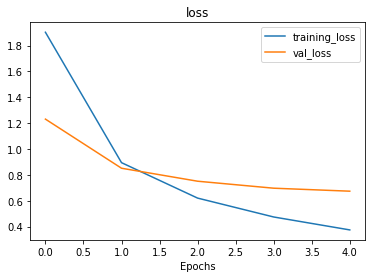

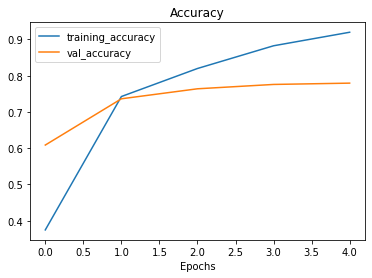

In [15]:
plot_loss_curves(history_resnet)

In [16]:
# creating efficient net architecture

In [17]:
efficientnet_model = create_model(efficientnet_url, train_data_10_percent.num_classes)

In [18]:
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

eff_history = efficientnet_model.fit(train_data_10_percent,
                                     epochs = 5,
                                     validation_data=test_data_10_percent,
                                     validation_steps = len(test_data_10_percent),
                                     steps_per_epoch= len(train_data_10_percent),
                                     callbacks = [create_tensorboard_callback("tensorflow_hub","efficientnetb0")])

Saving tensorboard log files to :tensorflow_hub/efficientnetb0/20210812-060909
Epoch 1/5
24/24 [==============================] - 26s 919ms/step - loss: 1.8345 - accuracy: 0.4280 - val_loss: 1.2889 - val_accuracy: 0.7264
Epoch 2/5
24/24 [==============================] - 19s 807ms/step - loss: 1.0394 - accuracy: 0.7787 - val_loss: 0.8691 - val_accuracy: 0.8052
Epoch 3/5
24/24 [==============================] - 19s 807ms/step - loss: 0.7461 - accuracy: 0.8267 - val_loss: 0.6988 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 19s 798ms/step - loss: 0.5999 - accuracy: 0.8613 - val_loss: 0.6127 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 18s 792ms/step - loss: 0.5124 - accuracy: 0.8813 - val_loss: 0.5594 - val_accuracy: 0.8624


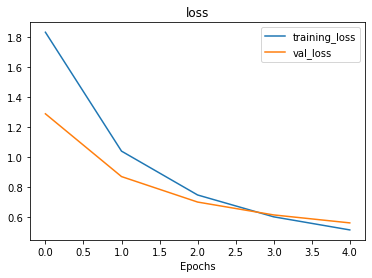

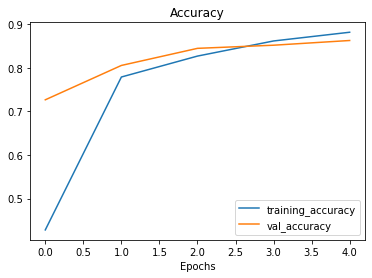

In [19]:
plot_loss_curves(eff_history)

Feature Extraction --> is a type of transfer learning where we use prelearned patterns of an existing model(eg efficientNEtb0 trained on ImageNEt) and adjust the output layer according to your own problem.<br>
Fine Tuning --> Using the already trained model and fine tuning the internal layers incuding the new output layers

Tensorboard is a way to visually explore your machine learning models performance and internals<br>
Host, track and share your machine learning experiments on TensorBoard.dev

In [ ]:
# Upload tensorboard 
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetb0 vs Resnet50v2" \
  --description "Comparing two different TF Hub feature extraction model architectures" \
  --one_shot

In [ ]:
#check what has already uploaded by you
!tensorboard dev list

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id ---------